In [14]:
# ==============================================================================
# Step 1: Setup and Load Data
# ==============================================================================
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.impute import SimpleImputer # Import the imputer


# Load the scaled data files from the previous step
X_train = pd.read_csv('X_train_scaled.csv')
X_test = pd.read_csv('X_test_scaled.csv')
y_train = pd.read_csv('y_train_final.csv').squeeze()
y_test = pd.read_csv('y_test_final.csv').squeeze()

print(" Scaled data files loaded successfully.")
print("Shape of training data:", X_train.shape)

 Scaled data files loaded successfully.
Shape of training data: (17411, 16)


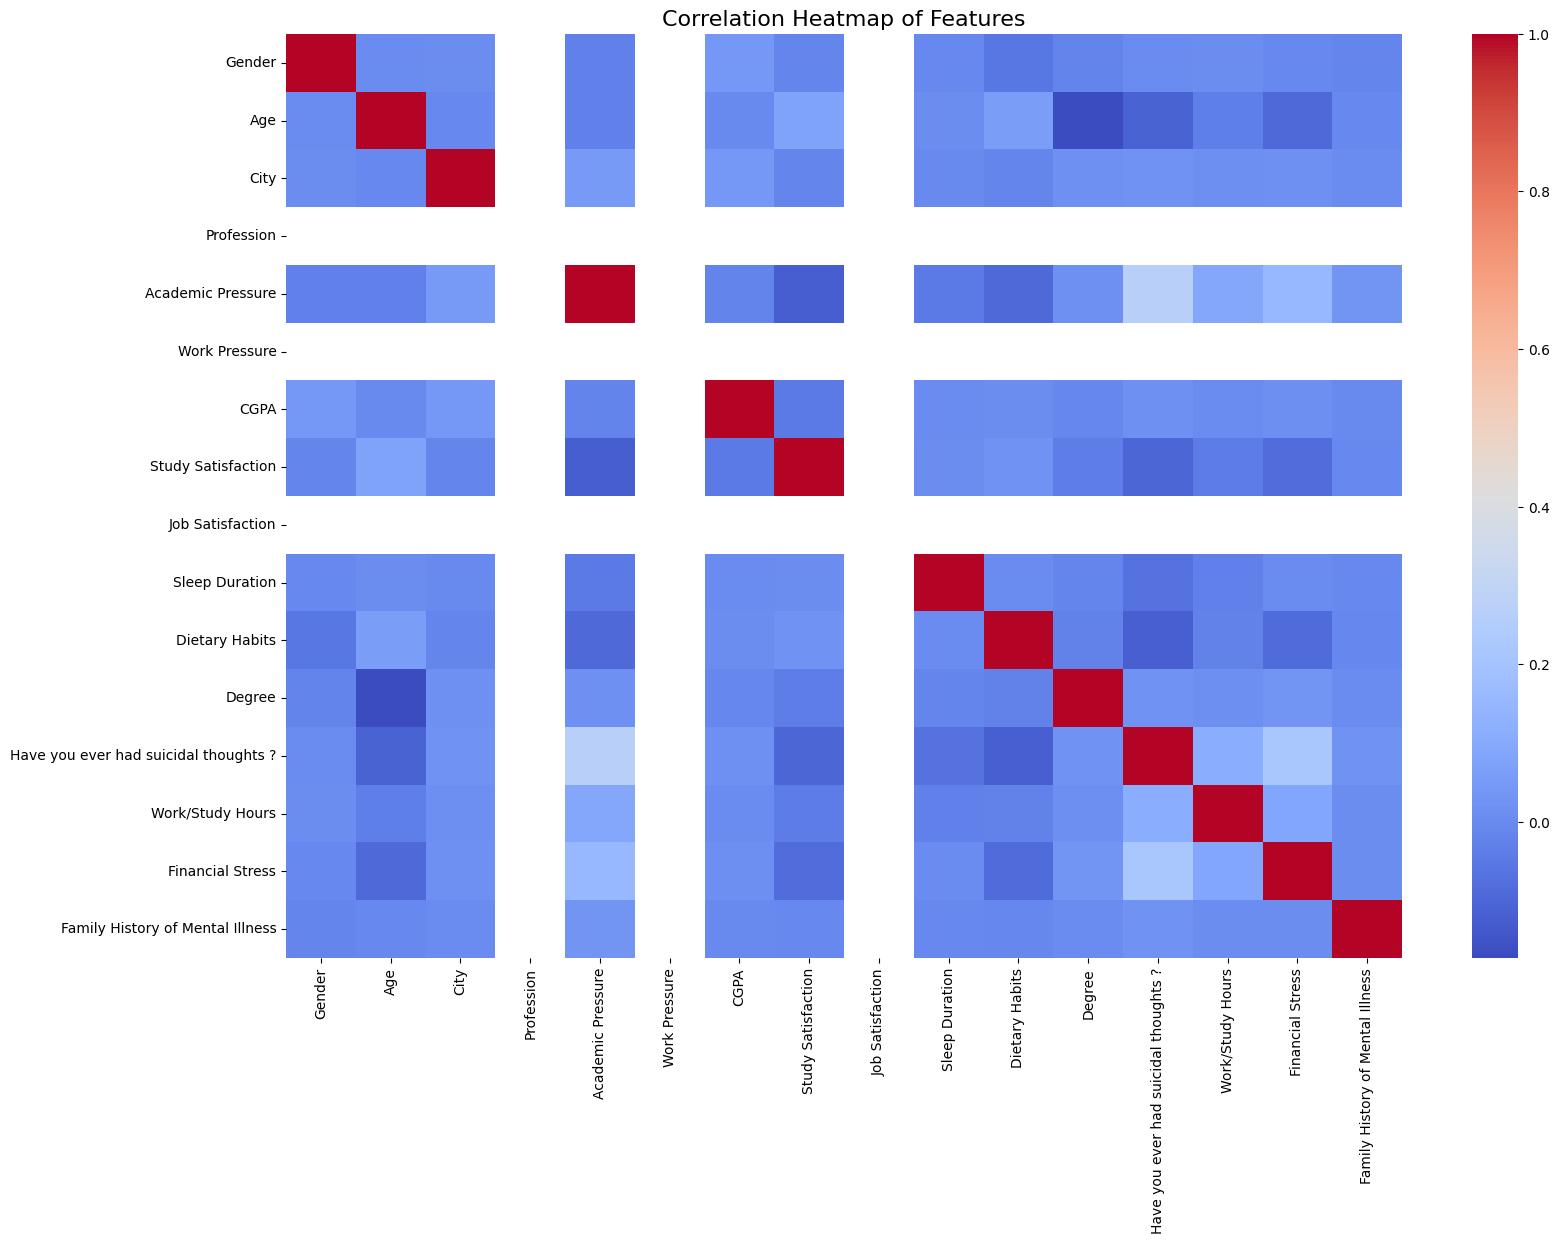


No features with correlation > 0.8 found to drop.
Shape of training data after correlation check: (17411, 16)


In [15]:
# ==============================================================================
# Step 2: Correlation Analysis
# ==============================================================================
plt.figure(figsize=(18, 12))
sns.heatmap(X_train.corr(), annot=False, cmap='coolwarm')
plt.title('Correlation Heatmap of Features', fontsize=16)
plt.show()

# --- Find and remove highly correlated features ---
# Create correlation matrix
corr_matrix = X_train.corr().abs()

# Select upper triangle of correlation matrix
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))

# Find index of feature columns with correlation greater than 0.8 (a common threshold)
to_drop = [column for column in upper.columns if any(upper[column] > 0.8)]

if not to_drop:
    print("\nNo features with correlation > 0.8 found to drop.")
else:
    print(f"\nDropping features with correlation > 0.8: {to_drop}")
    X_train = X_train.drop(to_drop, axis=1)
    X_test = X_test.drop(to_drop, axis=1)

print("Shape of training data after correlation check:", X_train.shape)

/usr/local/lib/python3.12/dist-packages/sklearn/feature_selection/_univariate_selection.py:111: UserWarning: Features [3 5 8] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
/usr/local/lib/python3.12/dist-packages/sklearn/feature_selection/_univariate_selection.py:112: RuntimeWarning: invalid value encountered in divide
  f = msb / msw


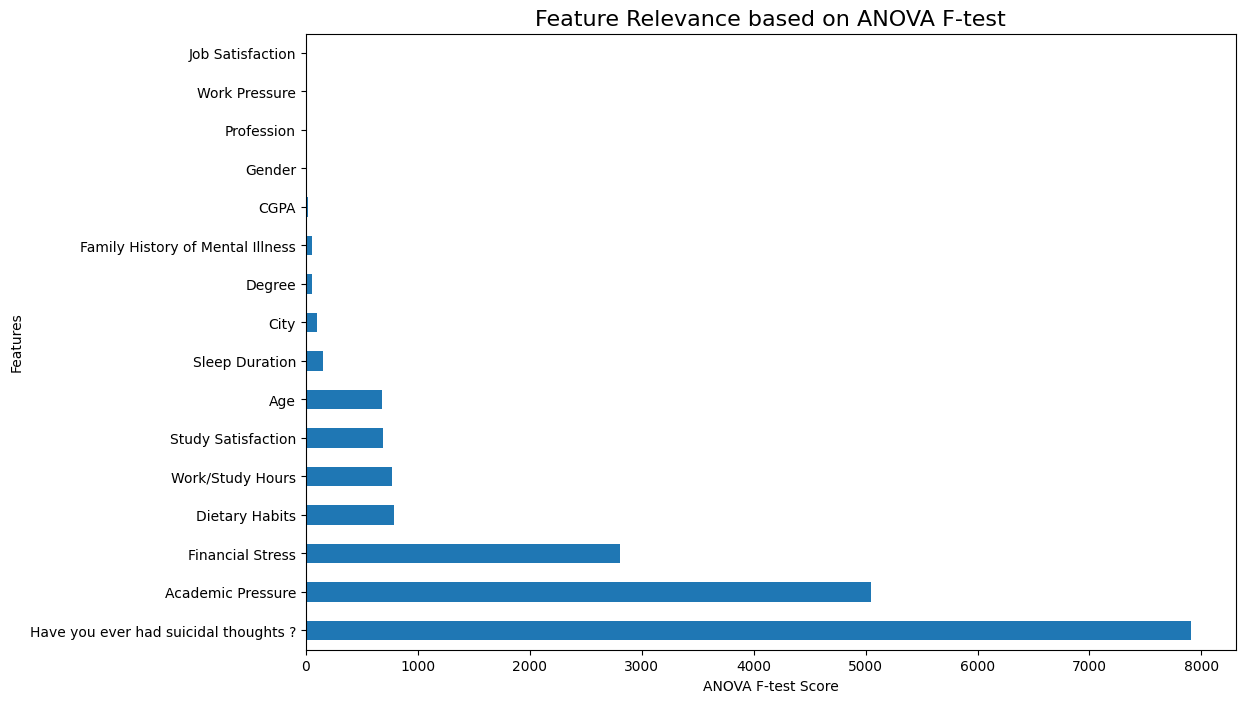


Kept the top 12 features based on F-scores.
Shape of data after ANOVA filter: (17411, 12)


In [16]:
# ==============================================================================
# Step 3: Filter for Relevance using ANOVA F-test
# ==============================================================================
# Use SelectKBest to get the F-scores for all features
imputer = SimpleImputer(strategy='mean')

# Fit on the training data and transform both sets
X_train = pd.DataFrame(imputer.fit_transform(X_train), columns=X_train.columns)
X_test = pd.DataFrame(imputer.transform(X_test), columns=X_test.columns)

f_selector = SelectKBest(score_func=f_classif, k='all')
f_selector.fit(X_train, y_train)
f_scores = pd.Series(f_selector.scores_, index=X_train.columns)

# --- EDA: Visualize the F-scores ---
# This is a key visualization for this new method.
plt.figure(figsize=(12, 8))
f_scores.sort_values(ascending=False).plot(kind='barh')
plt.xlabel("ANOVA F-test Score")
plt.ylabel("Features")
plt.title("Feature Relevance based on ANOVA F-test", fontsize=16)
plt.show()

# --- Prune the dataset based on F-scores ---
# We will keep the top 16 features to pass to the next stage
# This filters out the least statistically relevant features first.
top_12_f_features = f_scores.nlargest(12).index.tolist()
X_train_anova = X_train[top_12_f_features]
X_test_anova = X_test[top_12_f_features]

print(f"\nKept the top 12 features based on F-scores.")
print("Shape of data after ANOVA filter:", X_train_anova.shape)

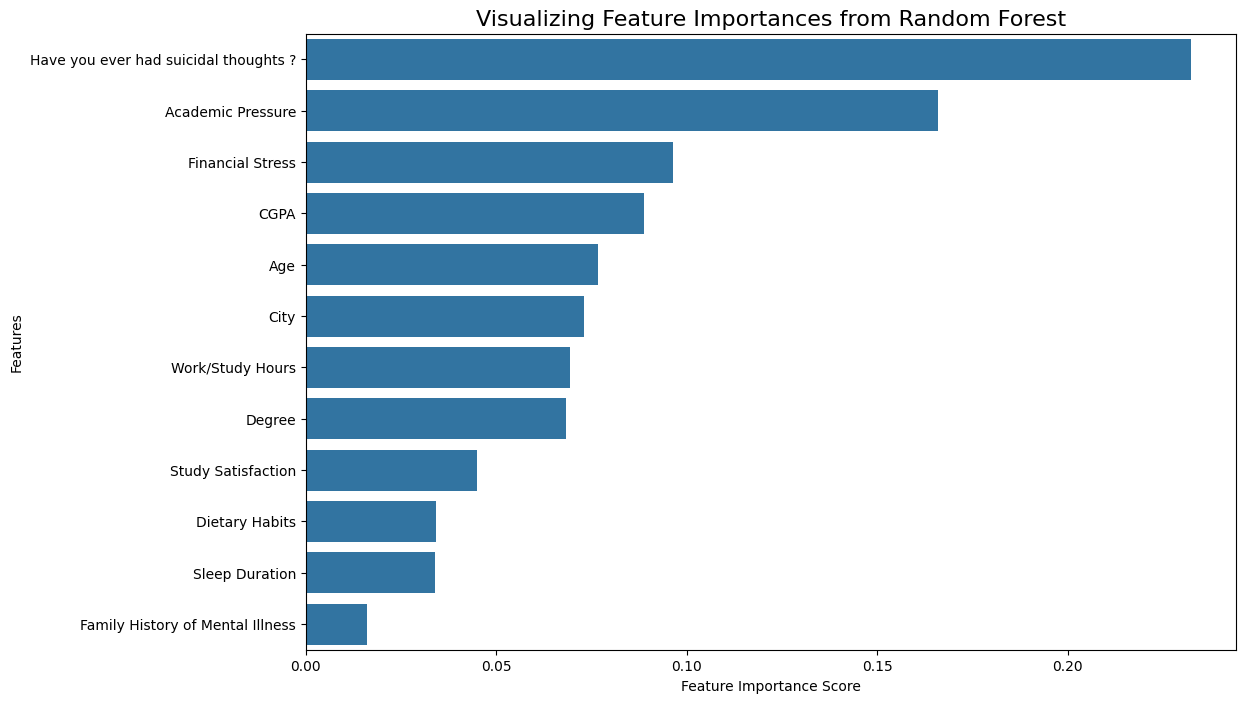

Feature Importances:
Have you ever had suicidal thoughts ?    0.232487
Academic Pressure                        0.165935
Financial Stress                         0.096391
CGPA                                     0.088740
Age                                      0.076645
City                                     0.073041
Work/Study Hours                         0.069335
Degree                                   0.068238
Study Satisfaction                       0.044936
Dietary Habits                           0.034296
Sleep Duration                           0.033914
Family History of Mental Illness         0.016042
dtype: float64


In [17]:
# ==============================================================================
# Step 3: Random Forest Feature Importance
# ==============================================================================
# Train a RandomForestClassifier to get feature importance scores
# random_state ensures reproducibility
model_rf = RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1)
model_rf.fit(X_train_anova, y_train)

# Create a pandas Series for easy plotting
importances = pd.Series(model_rf.feature_importances_, index=X_train_anova.columns)

# Sort the feature importances in descending order
sorted_importances = importances.sort_values(ascending=False)

# --- EDA: Visualize Feature Importances ---
plt.figure(figsize=(12, 8))
sns.barplot(x=sorted_importances, y=sorted_importances.index)
plt.xlabel("Feature Importance Score")
plt.ylabel("Features")
plt.title("Visualizing Feature Importances from Random Forest", fontsize=16)
plt.show()

print("Feature Importances:")
print(sorted_importances)

In [18]:
# ==============================================================================
# Step 4: Selecting the Final Set of Features
# ==============================================================================
# We will select the top 12 most important features as an example
# This number can be tuned later as a hyperparameter

N_FEATURES = 12
final_features = sorted_importances.nlargest(N_FEATURES).index.tolist()

print(f"\nSelected Top {N_FEATURES} Features: \n{final_features}")

# Create the final datasets with only the selected features
X_train_final = X_train_anova[final_features]
X_test_final = X_test_anova[final_features]

print(f"\nFinal shape of training data: {X_train_final.shape}")


Selected Top 12 Features: 
['Have you ever had suicidal thoughts ?', 'Academic Pressure', 'Financial Stress', 'CGPA', 'Age', 'City', 'Work/Study Hours', 'Degree', 'Study Satisfaction', 'Dietary Habits', 'Sleep Duration', 'Family History of Mental Illness']

Final shape of training data: (17411, 12)


In [19]:
# ==============================================================================
# Step 5: Save the Final Data for the Next Handoff (Model Training)
# ==============================================================================

# Save the final, feature-selected datasets
X_train_final.to_csv('X_train_final.csv', index=False)
X_test_final.to_csv('X_test_final.csv', index=False)

# Pass along the corresponding labels (these haven't changed)
y_train.to_csv('y_train_final.csv', index=False)
y_test.to_csv('y_test_final.csv', index=False)

print("\n✅ Handoff successful! Final feature-selected datasets have been saved.")


✅ Handoff successful! Final feature-selected datasets have been saved.
